In [1]:
from IPython.display import display
from sklearn import metrics
import pandas as pd
import numpy as np
import math
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

## 1-Reading the CSV File

In [83]:
df_raw = pd.read_csv("term-deposit-marketing-2020.csv",low_memory=False)

In [84]:
df_raw.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [85]:
df_raw.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

## 2-Pre-processing

In [86]:
df_compare = df_raw.copy()

In [87]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()
                   

In [88]:
# String to categorical 
train_cats(df_compare)


In [89]:
df_compare.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
y            category
dtype: object

In [90]:
df_compare.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [91]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1
        
def proc_df(df, y_fld):
    
    y = df[y_fld].values
    df.drop([y_fld], axis = 1, inplace = True)
        
    for n, c in df.items():
        numericalize(df, c, n)
    
    return [df, y]
    

In [92]:
# df_compare["y"] = df_compare["y"].cat.codes+1
df, y = proc_df(df_compare, 'y')

In [11]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,5,2,3,1,2143,2,1,3,5,9,261,1
1,44,10,3,2,1,29,2,1,3,5,9,151,1
2,33,3,2,2,1,2,2,2,3,5,9,76,1
3,47,2,2,4,1,1506,2,1,3,5,9,92,1
4,33,12,3,4,1,1,1,1,3,5,9,198,1


## 3-Score

In [12]:
x_train, x_test, y_train, y_test= train_test_split(df, y, test_size=0.2, random_state=7)

In [13]:
rf = RandomForestClassifier()
rf_score = cross_val_score(estimator=rf,X=x_train,y=y_train,cv=5)
rf.fit(x_train,y_train)

print("5-fold cross validation RandomForest : ", rf_score.mean())
print("RandomForest test score              : ", rf.score(x_test,y_test))

5-fold cross validation RandomForest :  0.93515625
RandomForest test score              :  0.937125


In [14]:
xgb = XGBClassifier()
xgb_score = cross_val_score(estimator=xgb,X=x_train,y=y_train,cv=5)
xgb.fit(x_train,y_train)

print("5-fold cross validation XGBost       : ", xgb_score.mean())
print("XGBost test score                    : ", xgb.score(x_test,y_test))

5-fold cross validation XGBost       :  0.9355
XGBost test score                    :  0.939


In [15]:
#Eğer manuel yöntemle k-fold uygulanırsa

kf = KFold(n_splits=5,shuffle=False)
accuracy_model = []
for train_index, test_index in kf.split(df):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model = rf.fit(X_train, Y_train)
    accuracy_model.append(accuracy_score(Y_test, model.predict(X_test), normalize=True)*100)
    
print("Manuel K-fold RandomForest score     : ",np.array(accuracy_model).mean())

Manuel K-fold RandomForest score     :  92.8925


## Bonuses


Hangi featurelar model için daha önemli bunu nasıl buluruz ?
M(x1,x2,x3...xn) = y
Burdaki özellikleri sıra sıra çıkararak çıkan y'lere göre başarı karşılaştırması yapabiliriz
Ama bu optimal değil:
1-Sürekli model üretmek maliyetli bir işlem olacaktır.
2-İki feature birbiriyle korele olabilir. Birini çıkarınca diğeri anlamsız bir şekilde etki edebilir.

Bizim bu featurelar arasındaki ilişkiyi kaybetmeden feature importance'a bakmamız gerekir.
Eğitim yaptığımız modelde interaction bilgisi mevcut. 
Eğer featurelar içerisindeki bilgileri random olarak shuffle yaparsak model sonucuna etkilerini ölçebilir
ve bu şekilde önemlerini ifade edebiliriz.



In [16]:
yes = df_raw[df_raw["y"]=="yes"].reset_index(drop=True)
no = df_raw[df_raw["y"]=="no"].reset_index(drop=True)

In [17]:
yes.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
2891,29,management,single,tertiary,no,637,yes,no,cellular,3,jun,340,1,yes
2892,55,management,divorced,tertiary,no,2383,no,no,cellular,3,jun,591,2,yes
2893,26,technician,single,secondary,no,1231,yes,no,cellular,3,jun,385,2,yes
2894,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
2895,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes


In [18]:
no.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
37099,32,management,married,tertiary,no,3154,no,no,cellular,3,jun,126,1,no
37100,35,management,married,tertiary,no,3109,yes,no,cellular,3,jun,467,1,no
37101,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
37102,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
37103,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no


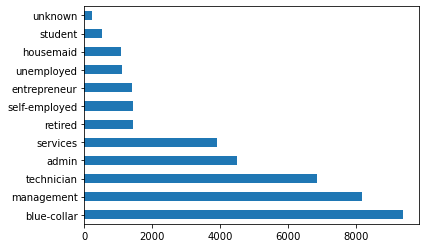

In [19]:
df_raw["job"].value_counts().plot.barh();

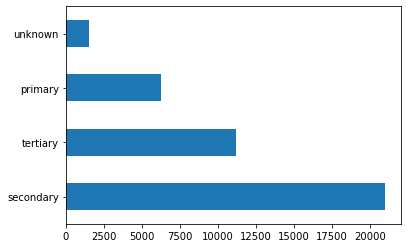

In [20]:
df_raw["education"].value_counts().plot.barh();

### Feature Importance

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [22]:
feature_importance = rf_feat_importance(rf, x_train);

In [23]:
feature_importance[:10]

,columns,importance
11,duration,0.402007
5,balance,0.122605
0,age,0.106755
9,day,0.093505
10,month,0.072552
1,job,0.055115
12,campaign,0.051301
3,education,0.029321
2,marital,0.022579
6,housing,0.014452


feature_importance ile hangi columnların daha etkili olduğunu görebiliyoruz

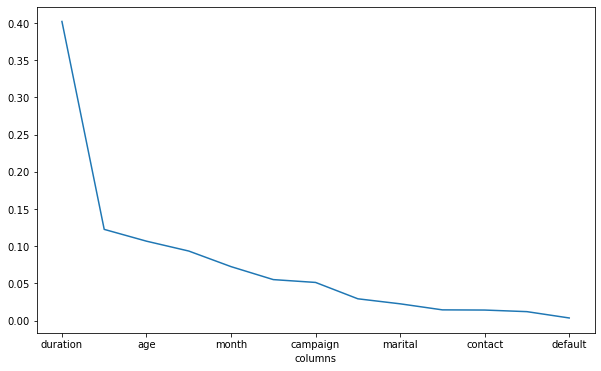

In [24]:
feature_importance.plot('columns', 'importance', figsize=(10,6), legend=False);

In [25]:
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

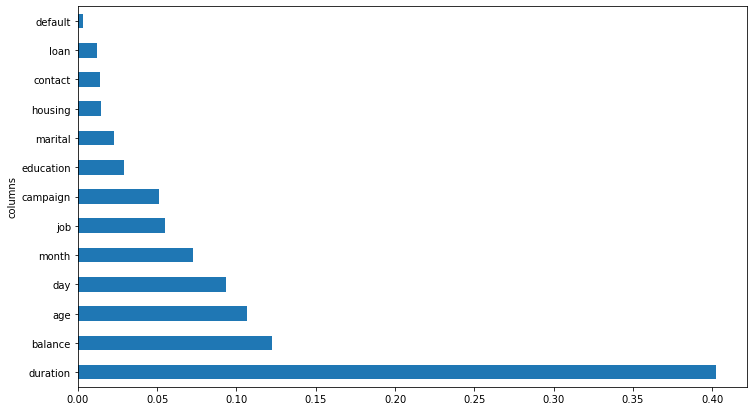

In [26]:
plot_feature_importance(feature_importance);

#Burdan feature'ların önem sıralarını görmekteyiz

In [27]:
#mesela 0.05'den küçük olan feature'ları atıp modelimizin ne sonuç vereceğine bakalım

In [28]:
rf = RandomForestClassifier()
rf_score = cross_val_score(estimator=rf,X=x_train.drop(feature_importance[feature_importance.importance<0.05]["columns"],axis=1),y=y_train,cv=5)
rf.fit(x_train.drop(feature_importance[feature_importance.importance<0.05]["columns"],axis=1),y_train)

print("5-fold cross validation RandomForest : ", rf_score.mean())
print("RandomForest test score              : ", rf.score(x_test.drop(feature_importance[feature_importance.importance<0.05]["columns"],axis=1),y_test))

5-fold cross validation RandomForest :  0.93215625
RandomForest test score              :  0.9345


In [36]:
import scipy
from scipy.cluster import hierarchy as hc
from matplotlib import pyplot as plt

In [148]:
rf = RandomForestClassifier()
rf_score = cross_val_score(estimator=rf,X=x_train,y=y_train,cv=5)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

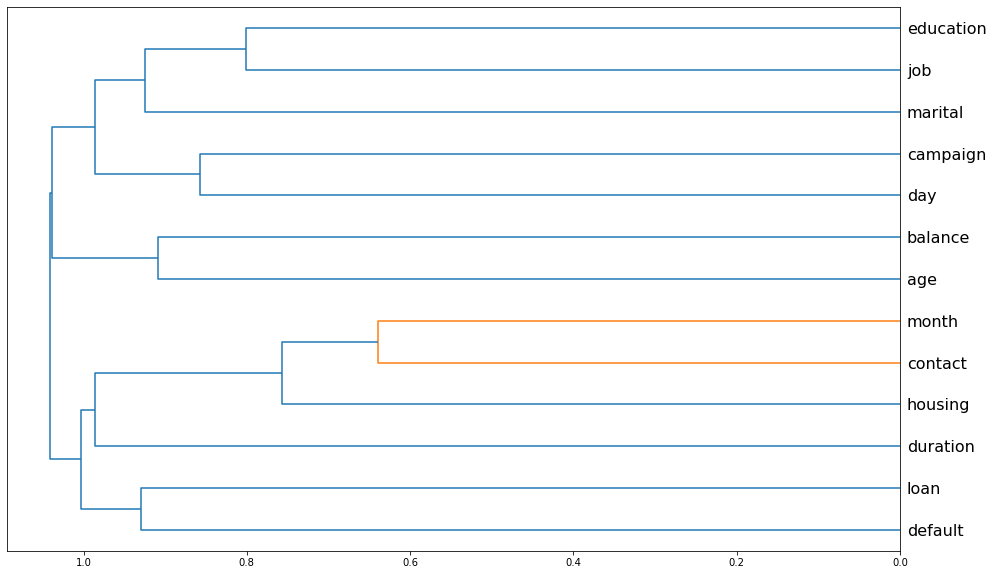

In [44]:
corr = np.round(scipy.stats.spearmanr(x_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=x_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [45]:
from pdpbox import pdp
from plotnine import *

## Partial Dependence

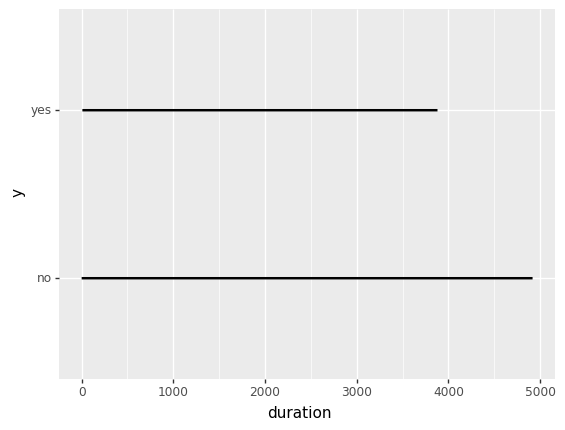

<ggplot: (-9223371959014865164)>

In [46]:
ggplot(df_raw, aes('duration', 'y'))+stat_smooth(se=True, method='lowess' )

In [47]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(rf, x_train, x_train.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [ ]:
plot_pdp('duration');

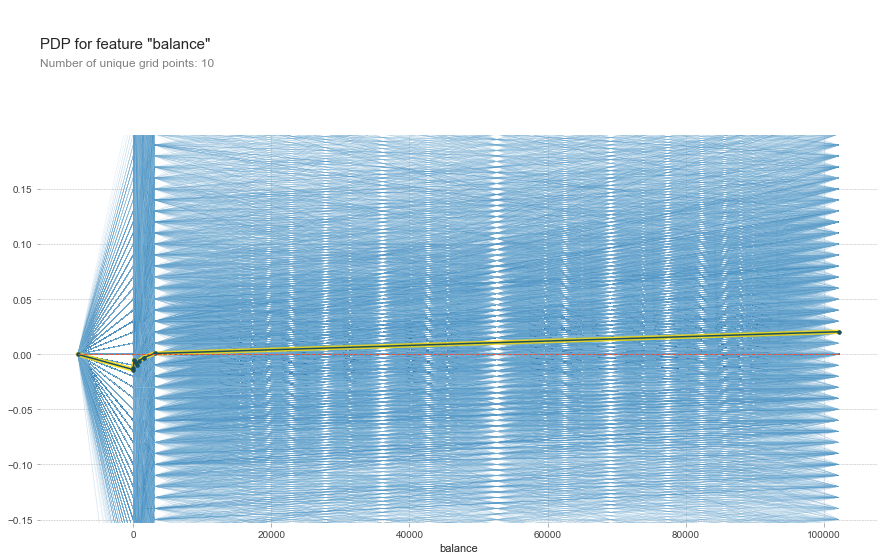

In [149]:
plot_pdp('balance');

In [49]:
df = df_raw.copy()

In [50]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [51]:
df.job.value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [52]:
df[['job','education']] = df[['job','education']].replace(['unknown'],'other')

In [53]:
condition3 = (df['education'] == 'other')
df = df.drop(df[condition3].index, axis = 0, inplace = False)

In [54]:
bardf=df.groupby(['education'])['balance'].median()
bardf

education
primary      365
secondary    363
tertiary     523
Name: balance, dtype: int64

In [55]:
print(bardf.idxmax(),' has highest median value with {}'.format(bardf.max()))

tertiary  has highest median value with 523


Text(0.5, 1.0, 'Grouping Education based on balance')

<Figure size 720x288 with 0 Axes>

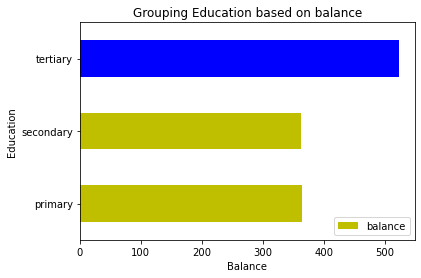

In [56]:
from matplotlib import *
import seaborn as sns
plt.figure(figsize=(10,4))
bardf=pd.DataFrame(bardf)
mycolors=('y','y','b')
bardf.plot.barh(color=mycolors)
plt.ylabel('Education')
plt.xlabel('Balance')
plt.title('Grouping Education based on balance')

In [57]:
num_var=list(df.select_dtypes(exclude='object').columns)
df[num_var]

,age,balance,day,duration,campaign
0,58,2143,5,261,1
1,44,29,5,151,1
2,33,2,5,76,1
5,35,231,5,139,1
6,28,447,5,217,1
...,...,...,...,...,...
39995,53,395,3,107,1
39996,30,3340,3,238,3
39997,54,200,3,170,1
39998,34,1047,3,342,1


In [58]:
cat_var=list(df.select_dtypes(exclude=[np.number]).columns)
df[cat_var]

,job,marital,education,default,housing,loan,contact,month,y
0,management,married,tertiary,no,yes,no,unknown,may,no
1,technician,single,secondary,no,yes,no,unknown,may,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,no
5,management,married,tertiary,no,yes,no,unknown,may,no
6,management,single,tertiary,no,yes,yes,unknown,may,no
...,...,...,...,...,...,...,...,...,...
39995,technician,married,tertiary,no,no,no,cellular,jun,no
39996,management,single,tertiary,no,no,no,cellular,jun,yes
39997,admin,divorced,secondary,no,no,no,cellular,jun,yes
39998,management,married,tertiary,no,no,no,cellular,jun,no


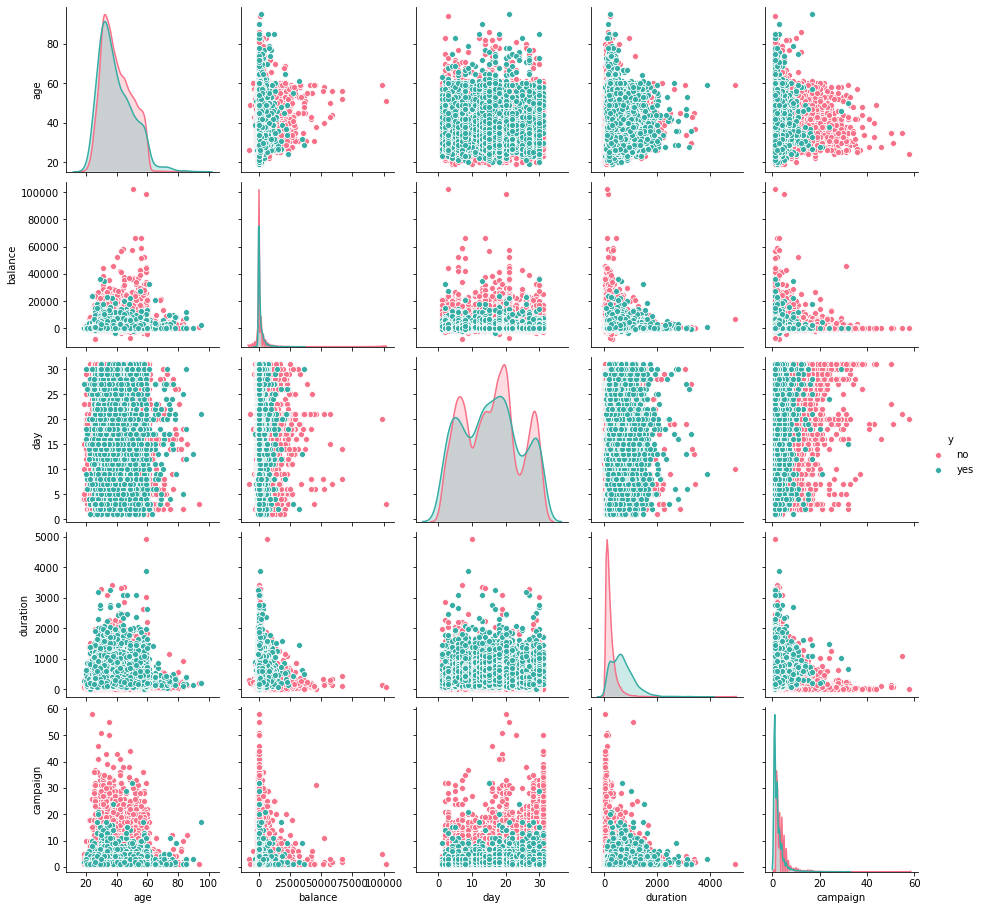

In [59]:
sns.pairplot(df, hue='y', palette="husl")

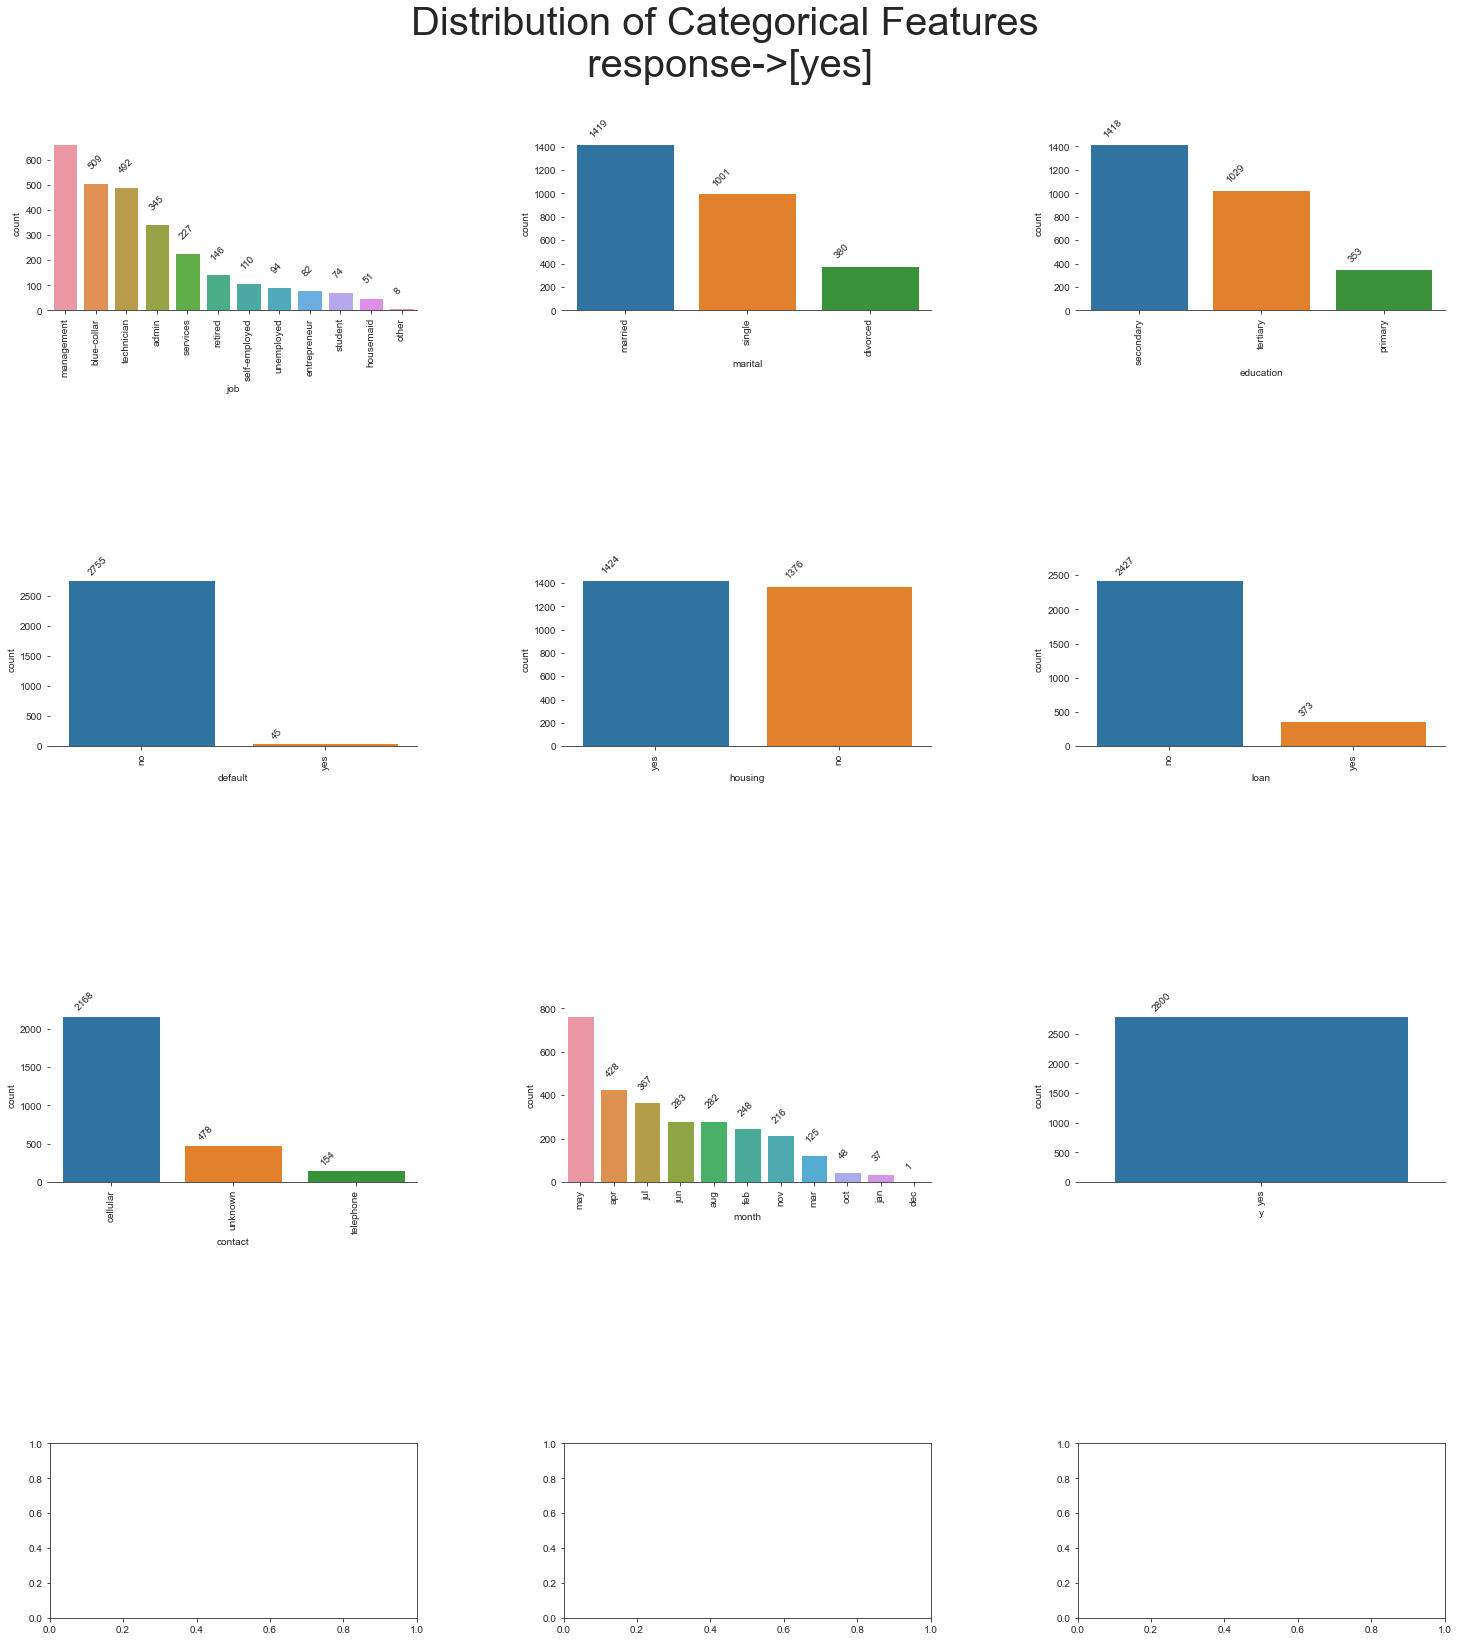

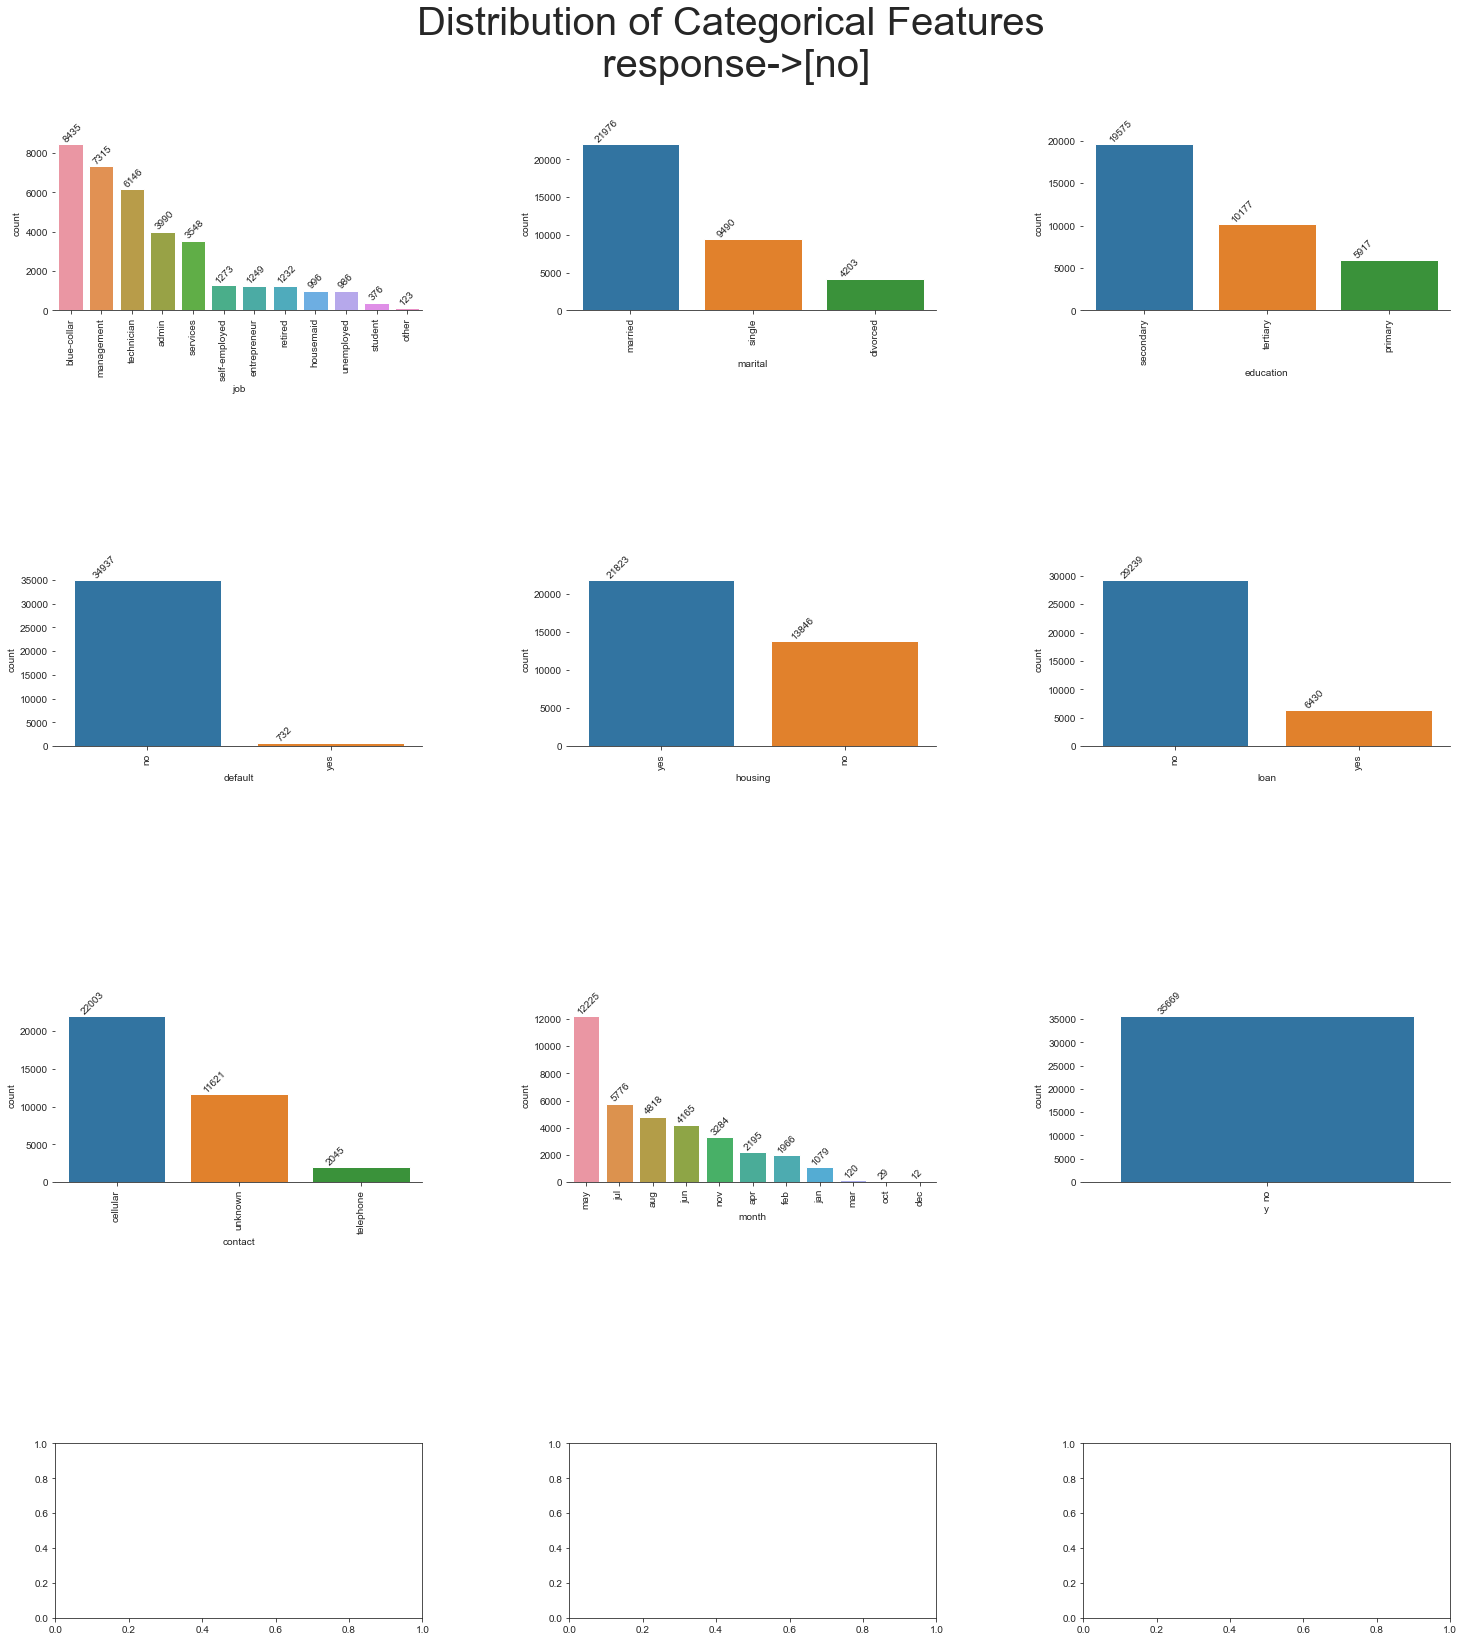

In [60]:
#özelliklere göre yes ve no dağılımları
res=['yes','no']
for i in res:
    sns.set_style("ticks")
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 21))
    fig.suptitle("Distribution of Categorical Features\n response->[{}]".format(i),
             horizontalalignment='center', y=1.05,
             verticalalignment='center', fontsize=40)
    fig.subplots_adjust(top=0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    for ax, c in list(zip(axes.flat, cat_var)):        
        sns.countplot(c, data=df[df['y']=='{}'.format(i)],order= df[df['y']=='{}'.format(i)][c].value_counts().index,
                  ax=ax)
        for p in ax.patches:
            ax.annotate("{}".format(p.get_height()), (p.get_x()+0.1, p.get_height()+50),
                       ha='left', va='bottom', rotation=45)
        ax.tick_params(labelrotation=90)  
        plt.sca(ax)
        plt.yticks(rotation=0)    
         # ax.axis('off')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(False)

In [61]:
df_grouped = df.groupby("y")
class_name_no = "no"
class_name_yes = "yes"
df_grouped_no = df_grouped.get_group(class_name_no)
df_grouped_yes =df_grouped.get_group(class_name_yes)

Text(0, 0.5, 'Count')

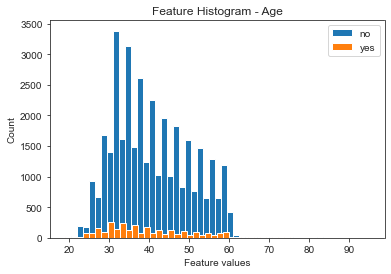

In [62]:

plt.figure()
plt.hist(df_grouped_no['age'], bins=50, label=class_name_no)
plt.hist(df_grouped_yes['age'], bins=50, label=class_name_yes)
plt.legend()
plt.title("Feature Histogram - Age")
plt.xlabel("Feature values")
plt.ylabel("Count")

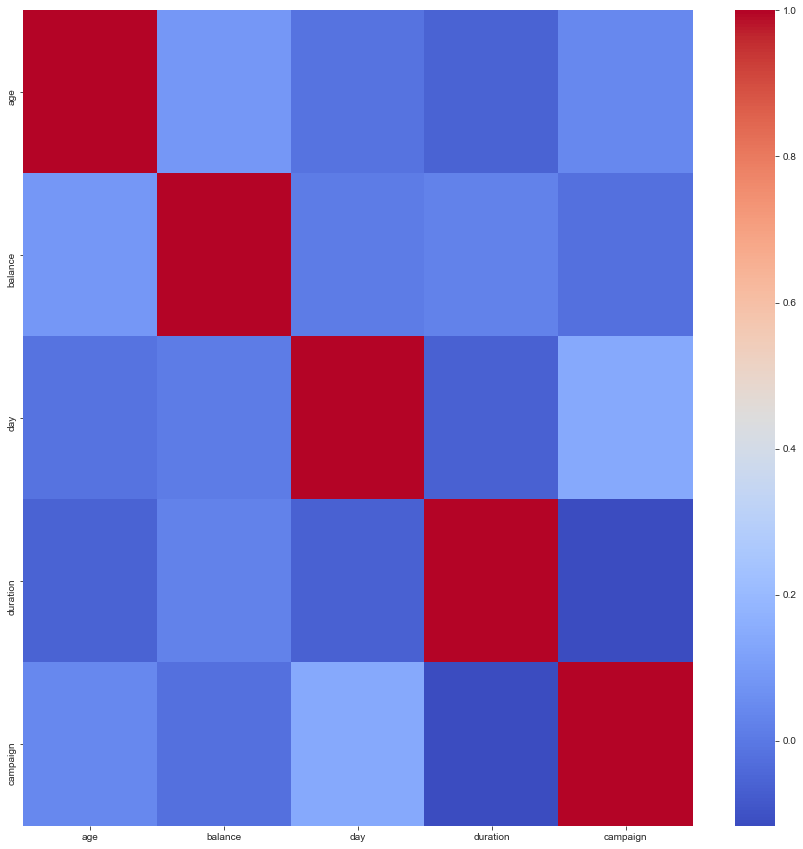

In [63]:
#HEAT MAP

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(method='spearman'), annot=False, cmap='coolwarm')

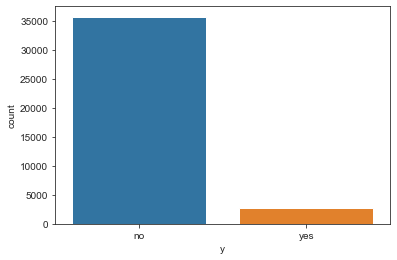

In [64]:
sns.countplot(x='y', data=df)

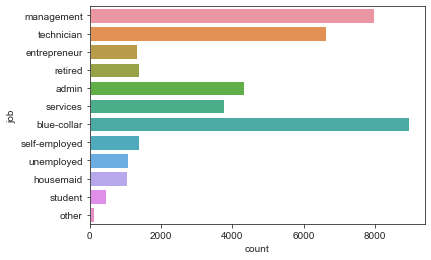

In [65]:
sns.countplot(y='job', data=df)

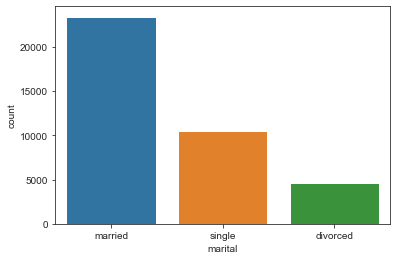

In [66]:
sns.countplot(x='marital', data=df)

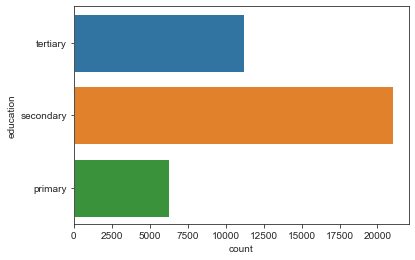

In [67]:
sns.countplot(y='education', data=df)

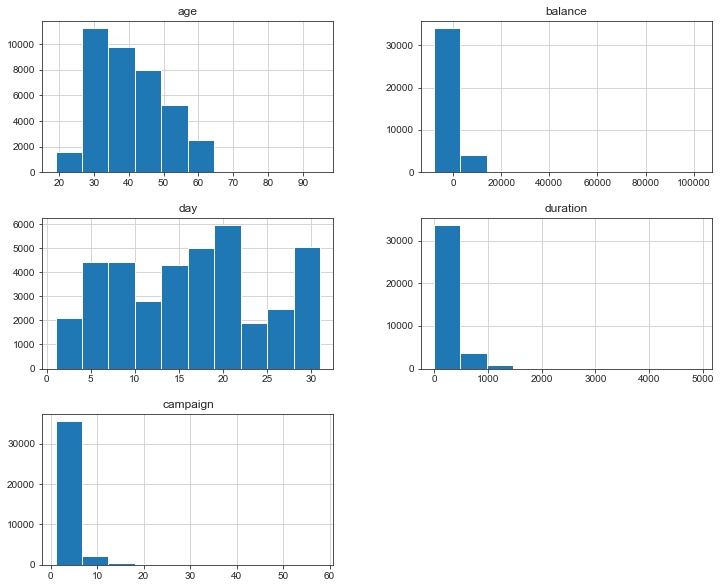

In [68]:
dist=df.hist(figsize=(12,10)) # numerik feature dağılımı

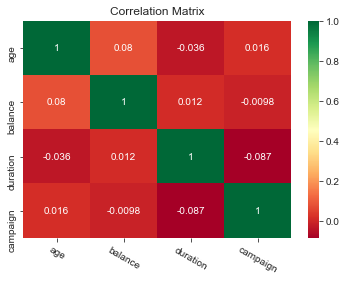

In [69]:
corr_data = df[['age','balance','duration','campaign','month','y']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn')
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()